In [1]:
import pandas as pd
import numpy as np
import time
import scanpy as sc
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from anndata import AnnData
from anndata.experimental.pytorch import AnnLoader
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import TruncatedSVD

import biomart
import prototypical_network
import helper_fns
import vanilla_vae
from model import PL, Net, train, train_knn, train_logistic_regression

In [2]:
dataset_popv = sc.read("/Volumes/SSD/popv_immune.h5ad")
dataset_celltypist = sc.read("/Volumes/SSD/global.h5ad")
list_celltypes = dataset_popv.obs['cell_type'].unique().tolist()
encoder_celltype = LabelEncoder()
encoder_celltype.fit(dataset_popv.obs['cell_type'])
list_ct = dataset_popv.obs['cell_type'].unique().tolist()
list_num_ct = encoder_celltype.transform(list_ct)
list_inner_nodes = ['popv_immune', 'myeloid leukocyte', 'mature B cell', 'NK', 'CD4', 'CD8']
all_nodes = list_ct + list_inner_nodes

encoder_celltype_inner = LabelEncoder()
encoder_celltype_inner.fit(list_inner_nodes)

g = helper_fns.build_hierarchical_tree_popv_immune(all_nodes=all_nodes, list_ct=list_ct, list_inner_nodes=list_inner_nodes, encoder_celltype=encoder_celltype, encoder_celltype_inner=encoder_celltype_inner)

dist_df = helper_fns.get_dist_df(list_num_ct=list_num_ct, g=g)
D = torch.tensor(dist_df.values, dtype=float)
ensembl_to_genesymbol = helper_fns.get_ensembl_mappings()

genes_celltypist = dataset_celltypist.var_names
genes_popv = dataset_popv.var_names
not_found = []
found_hgnc = []
found_ensembl = []
for i in range(len(list(genes_celltypist))):
    try:
        a = ensembl_to_genesymbol[genes_celltypist[i]]
        if a not in genes_popv:
            not_found.append(genes_celltypist[i])
        else:
            found_hgnc.append(genes_celltypist[i])
            found_ensembl.append(a)
    except KeyError:
        not_found.append(genes_celltypist[i])

# filter the anndata by the found_ensembl genes
dataset_popv = dataset_popv[:,found_ensembl]
dataset_celltypist = dataset_celltypist[:,found_hgnc]

train_indices, test_indices, cv = helper_fns.costumized_train_test_split(dataset_popv, cross_validation=False, k_fold=5, obs_key='cell_type')
sc.pp.normalize_total(dataset_popv, 1e4)
sc.pp.log1p(dataset_popv)
pca = TruncatedSVD(n_components=128)
pca.fit(dataset_popv[train_indices].X)
dataset_popv_pca = AnnData(pca.transform(dataset_popv.X))
dataset_popv_pca.obs = dataset_popv.obs

train_subsampler = torch.utils.data.SubsetRandomSampler(train_indices)
test_subsampler = torch.utils.data.SubsetRandomSampler(test_indices)

# Define data loaders for training and testing data in this fold
encoders = {
    'obs': {
        'cell_type': encoder_celltype.transform
    }
}
dataloader_training = AnnLoader(dataset_popv_pca, batch_size=512, convert=encoders, sampler=train_subsampler)
dataloader_testing = AnnLoader(dataset_popv_pca, batch_size=512, convert=encoders, sampler=test_subsampler)


# Label encoder // No problem
encoder_celltype_celltypist = LabelEncoder()
encoder_celltype_celltypist.fit(dataset_celltypist.obs['Manually_curated_celltype'])

sc.pp.normalize_total(dataset_celltypist, 1e4)
sc.pp.log1p(dataset_celltypist)
dataset_celltypist_pca = AnnData(pca.transform(dataset_celltypist.X))
dataset_celltypist_pca.obs = dataset_celltypist.obs

/Users/xbh0403/opt/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/xbh0403/opt/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


/Users/xbh0403/Desktop/HCell/model.py:88: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:204.)
  centers = torch.tensor(centers, dtype=float)


Epoch 1
Train ER 51.77, time 7.8s
Test ER 53.29, time 0.7s
Epoch 2
Train ER 45.40, time 6.7s
Test ER 42.95, time 0.6s
Epoch 3
Train ER 40.71, time 6.6s
Test ER 38.25, time 0.6s
Epoch 4
Train ER 35.87, time 6.6s
Test ER 35.43, time 0.7s
Epoch 5
Train ER 32.88, time 6.5s
Test ER 31.82, time 0.6s
Epoch 6
Train ER 30.70, time 6.6s
Test ER 29.91, time 0.6s
Epoch 7
Train ER 29.48, time 6.5s
Test ER 28.84, time 0.6s
Epoch 8
Train ER 28.14, time 6.5s
Test ER 28.34, time 0.6s
Epoch 9
Train ER 27.20, time 6.5s
Test ER 28.58, time 0.7s
Epoch 10
Train ER 26.49, time 6.5s
Test ER 25.97, time 0.6s
Epoch 11
Train ER 25.58, time 6.6s
Test ER 26.49, time 0.6s
Epoch 12
Train ER 24.98, time 6.5s
Test ER 24.54, time 0.7s
Epoch 13
Train ER 24.25, time 6.6s
Test ER 24.09, time 0.6s
Epoch 14
Train ER 23.75, time 6.6s
Test ER 24.15, time 0.6s
Epoch 15
Train ER 23.79, time 6.5s
Test ER 24.01, time 0.6s
Epoch 16
Train ER 23.22, time 6.6s
Test ER 23.44, time 0.7s
Epoch 17
Train ER 22.98, time 6.5s
Test ER 23.01,

/Users/xbh0403/Desktop/HCell/helper_fns.py:305: RuntimeWarning: invalid value encountered in true_divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


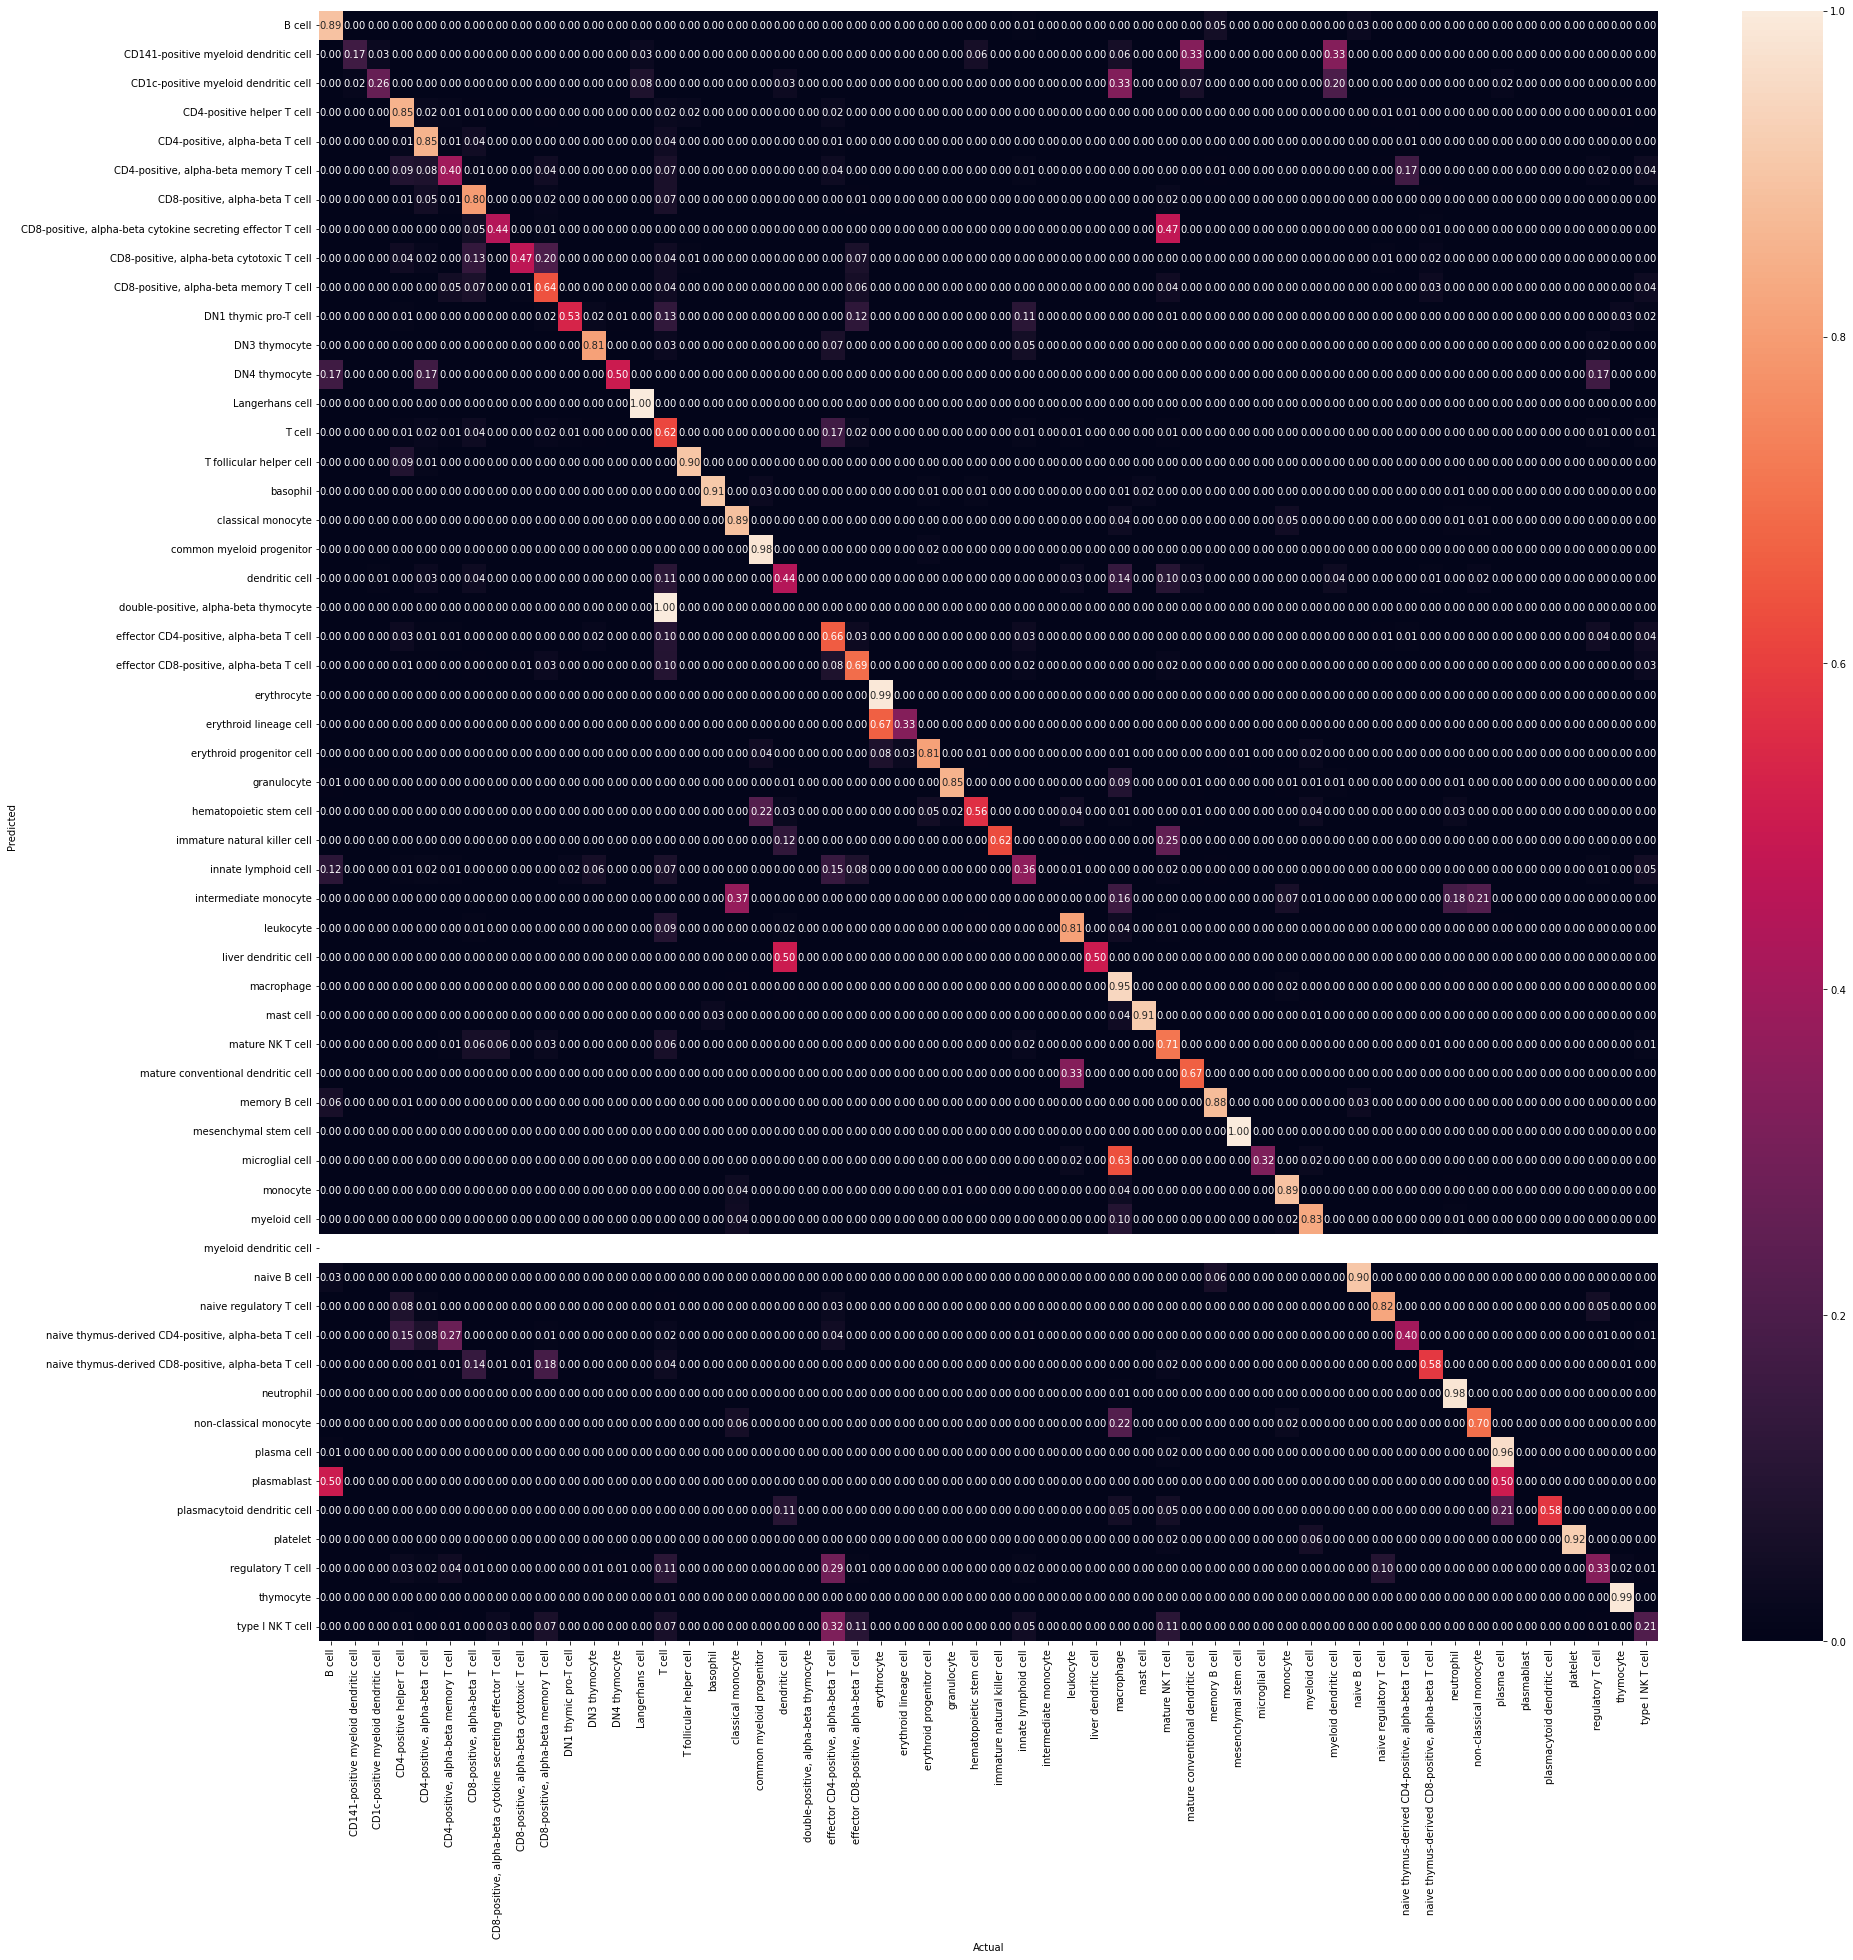

In [3]:
weights = helper_fns.get_weights(num_celltypes=len(list_num_ct), dataset=dataset_popv_pca, encoder=encoder_celltype, obs='cell_type')
model = train(mode='Proto_Net', loss_mode='disto_pl', epochs=50, embedding_dim=16, D=D, num_celltypes=list_num_ct, 
    encoder=encoder_celltype, dataset=dataset_popv_pca, dataloader_training=dataloader_training, dataloader_testing=dataloader_testing, 
    obs_name='cell_type', init_weights=weights)
embedding_prototypes, embedding_prototypes_labels = helper_fns.get_prototypes_and_labels(model=model, encoder=encoder_celltype, num_celltypes=len(list_num_ct))
helper_fns.plot_confusion_matrix('Proto_Net', model, dataset=dataset_popv_pca, encoder=encoder_celltype, test_indices=test_indices, obs_name='cell_type')

In [5]:
model_logistic = train_logistic_regression(dataset=dataset_popv_pca, train_indices=train_indices, test_indices=test_indices, encoder=encoder_celltype, obs_name='cell_type')
model_knn = train_knn(dataset=dataset_popv_pca, train_indices=train_indices, test_indices=test_indices, encoder=encoder_celltype, obs_name='cell_type')

/Users/xbh0403/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression
Train error: 19.517283041664303%
Test error: 19.83566301473366%
kNN
Train error: 10.217855052764724%
Test error: 14.748772194937665%


In [6]:
test_celltypes = ['Memory B cells', 'Naive B cells', 'Tfh', 'Plasma cells', 'Tregs']
train_celltypes = ['memory B cell', 'naive B cell', 'T follicular helper cell', 'plasma cell', 'regulatory T cell']

In [7]:
train_embeddings, training_preds = helper_fns.get_embeddings_and_out(model, dataset_popv_pca[train_indices], encoder=encoder_celltype)
test_embeddings, test_preds = helper_fns.get_embeddings_and_out(model, dataset_celltypist_pca, encoder=encoder_celltype)
prototypes, prototypes_labels = helper_fns.get_prototypes_and_labels(model, encoder=encoder_celltype, num_celltypes=len(list_num_ct))

True positive memory B cell: 91.3753508548099%
{'Naive B cells': 680, 'ABCs': 243, 'Cycling': 17, 'Pre-B': 18, 'Pro-B': 10, 'Tregs': 58, 'Tfh': 23, 'Plasma cells': 21, 'Tem/emra_CD8': 16, 'T_CD4/CD8': 34, 'ILC3': 19, 'Teffector/EM_CD4': 5, 'Tnaive/CM_CD4': 4, 'Trm/em_CD8': 6, 'Tnaive/CM_CD8': 1, 'GC_B (II)': 20, 'Trm_Th1/Th17': 1, 'DC2': 59, 'GC_B (I)': 24, 'migDC': 5, 'Intestinal macrophages': 3, 'Alveolar macrophages': 1, 'Erythrophagocytic macrophages': 4, 'Classical monocytes': 2, 'DC1': 2, 'Nonclassical monocytes': 1, 'Cycling T&NK': 8, 'Plasmablasts': 67}


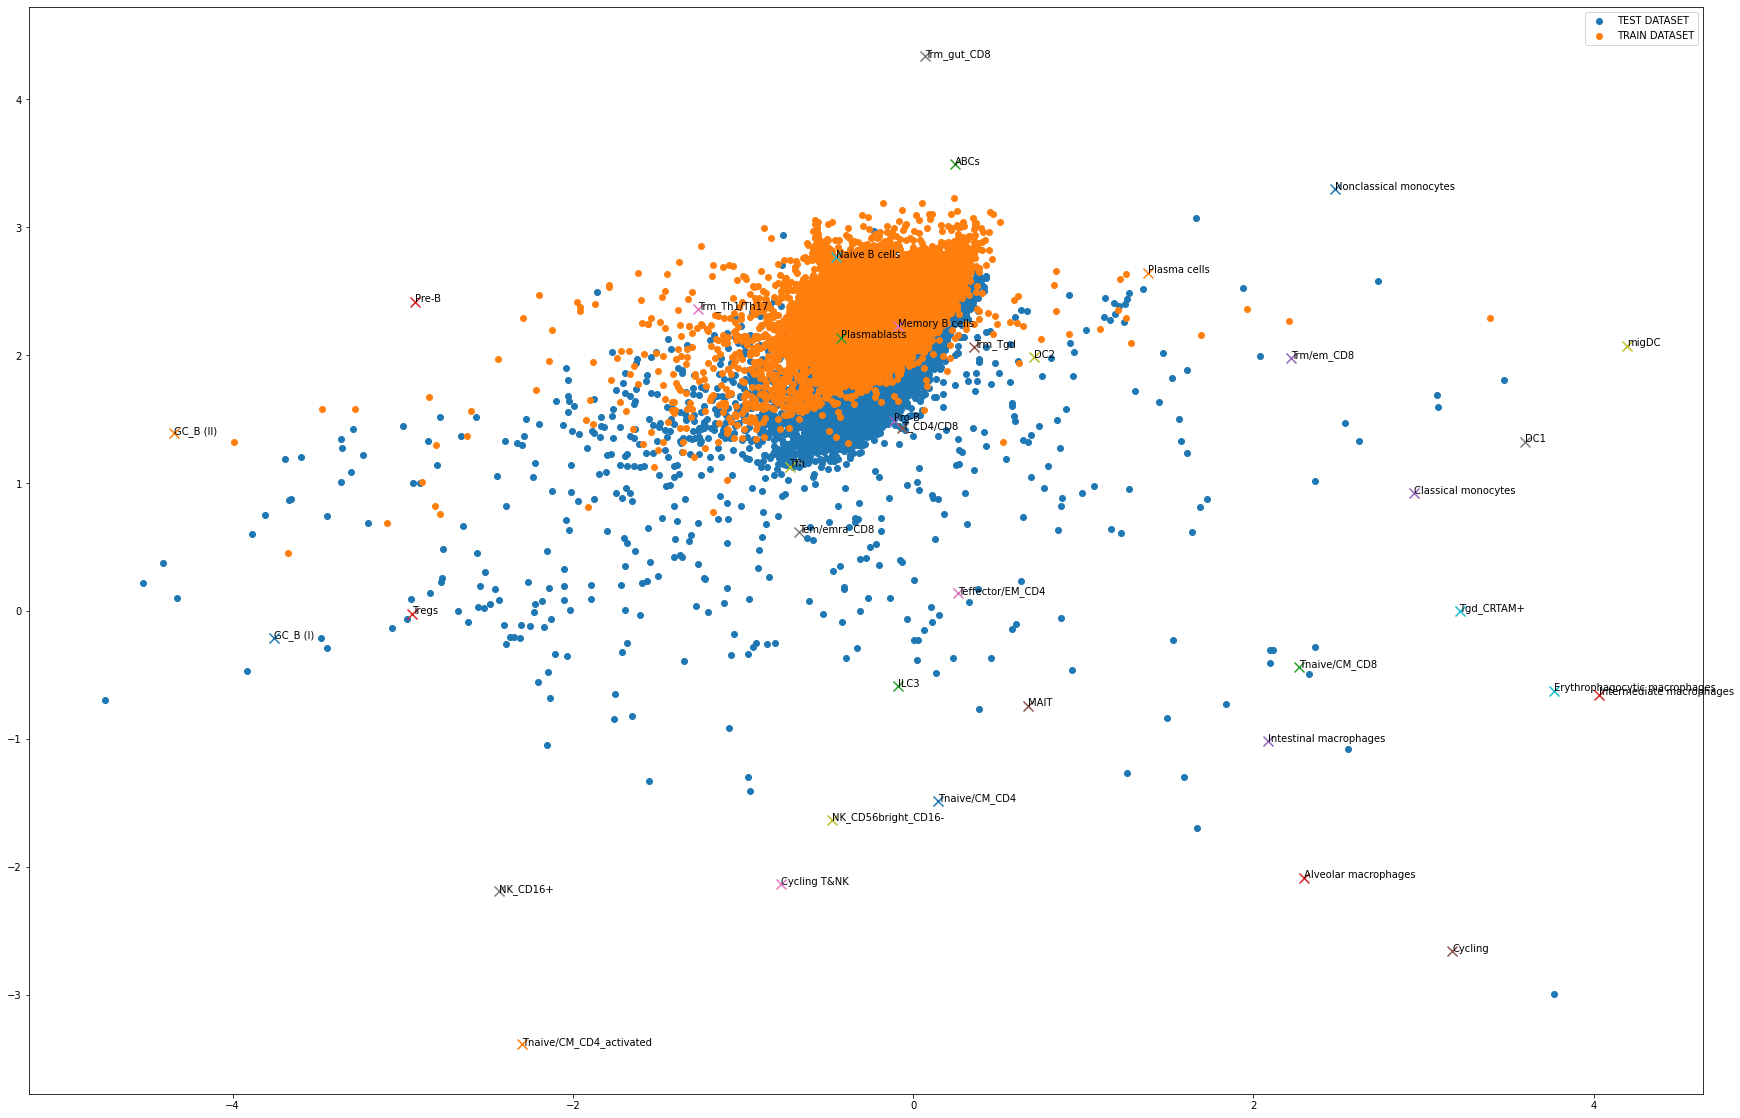

In [ ]:
# helper_fns.plot_embeddings_given_labels_and_datasets(train_embeddings=train_embeddings, test_embeddings=test_embeddings,
#  train_true_labels=dataset_celltypist_pca[train_indices].obs['Manually_curated_celltype'], test_true_labels=dataset_popv_pca.obs['cell_type'],
#  test_pred_labels=test_preds, train_celltype='Memory B cells', test_celltype='memory B cell', prototypes=prototypes, prototypes_labels=prototypes_labels)

True positive naive B cell: 93.18148202928562%
{'Memory B cells': 434, 'Pre-B': 5, 'Tem/emra_CD8': 2, 'DC2': 1, 'ABCs': 2, 'Cycling': 1, 'GC_B (II)': 1, 'Tregs': 2, 'T_CD4/CD8': 2, 'migDC': 1, 'Tnaive/CM_CD4': 2, 'Pro-B': 1, 'Classical monocytes': 2, 'Plasmablasts': 2, 'Cycling T&NK': 1, 'ILC3': 1, 'Plasma cells': 1}


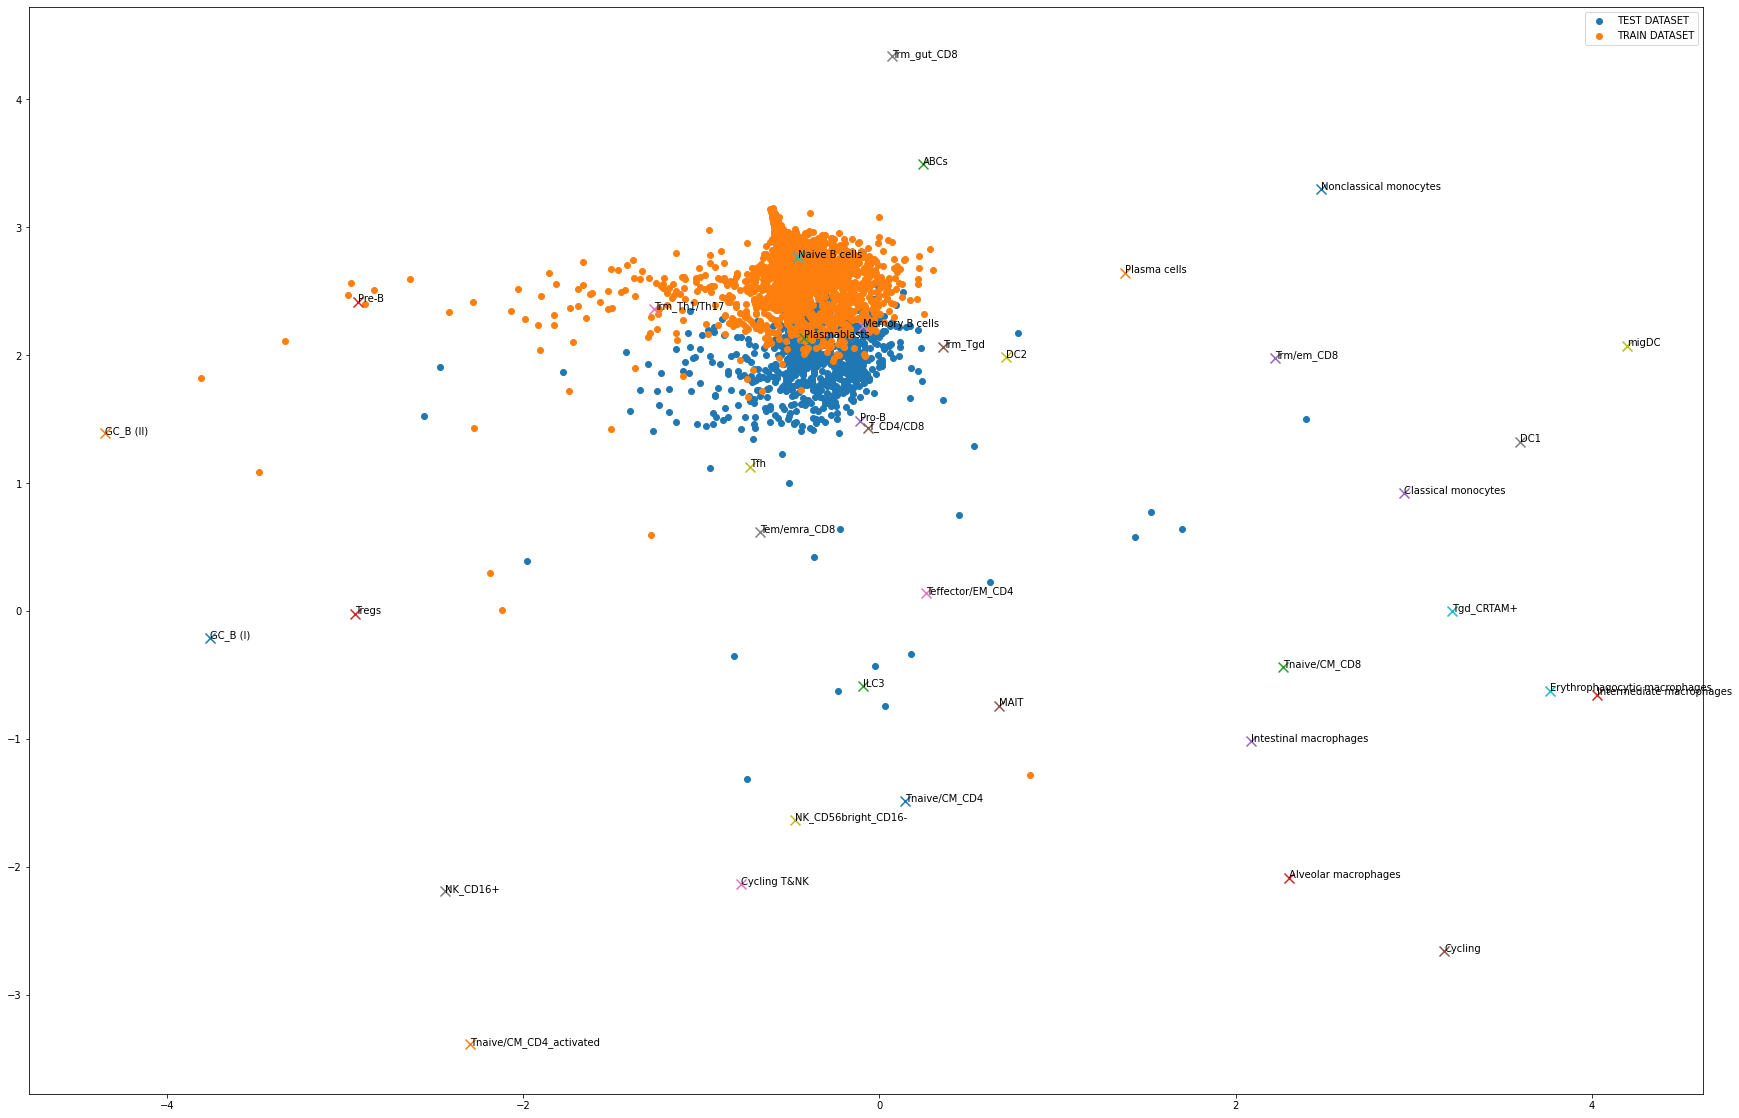

In [ ]:
# helper_fns.plot_embeddings_given_labels_and_datasets(train_embeddings=train_embeddings, test_embeddings=test_embeddings,
#  train_true_labels=dataset_celltypist_pca[train_indices].obs['Manually_curated_celltype'], test_true_labels=dataset_popv_pca.obs['cell_type'],
#  test_pred_labels=test_preds, train_celltype='Naive B cells', test_celltype='naive B cell', prototypes=prototypes, prototypes_labels=prototypes_labels)

True positive T follicular helper cell: 30.402010050251256%
{'Teffector/EM_CD4': 83, 'Tnaive/CM_CD4': 147, 'Trm_Th1/Th17': 23, 'Tregs': 13, 'Tnaive/CM_CD8': 5, 'Trm_gut_CD8': 2, 'T_CD4/CD8': 1, 'Trm/em_CD8': 3}


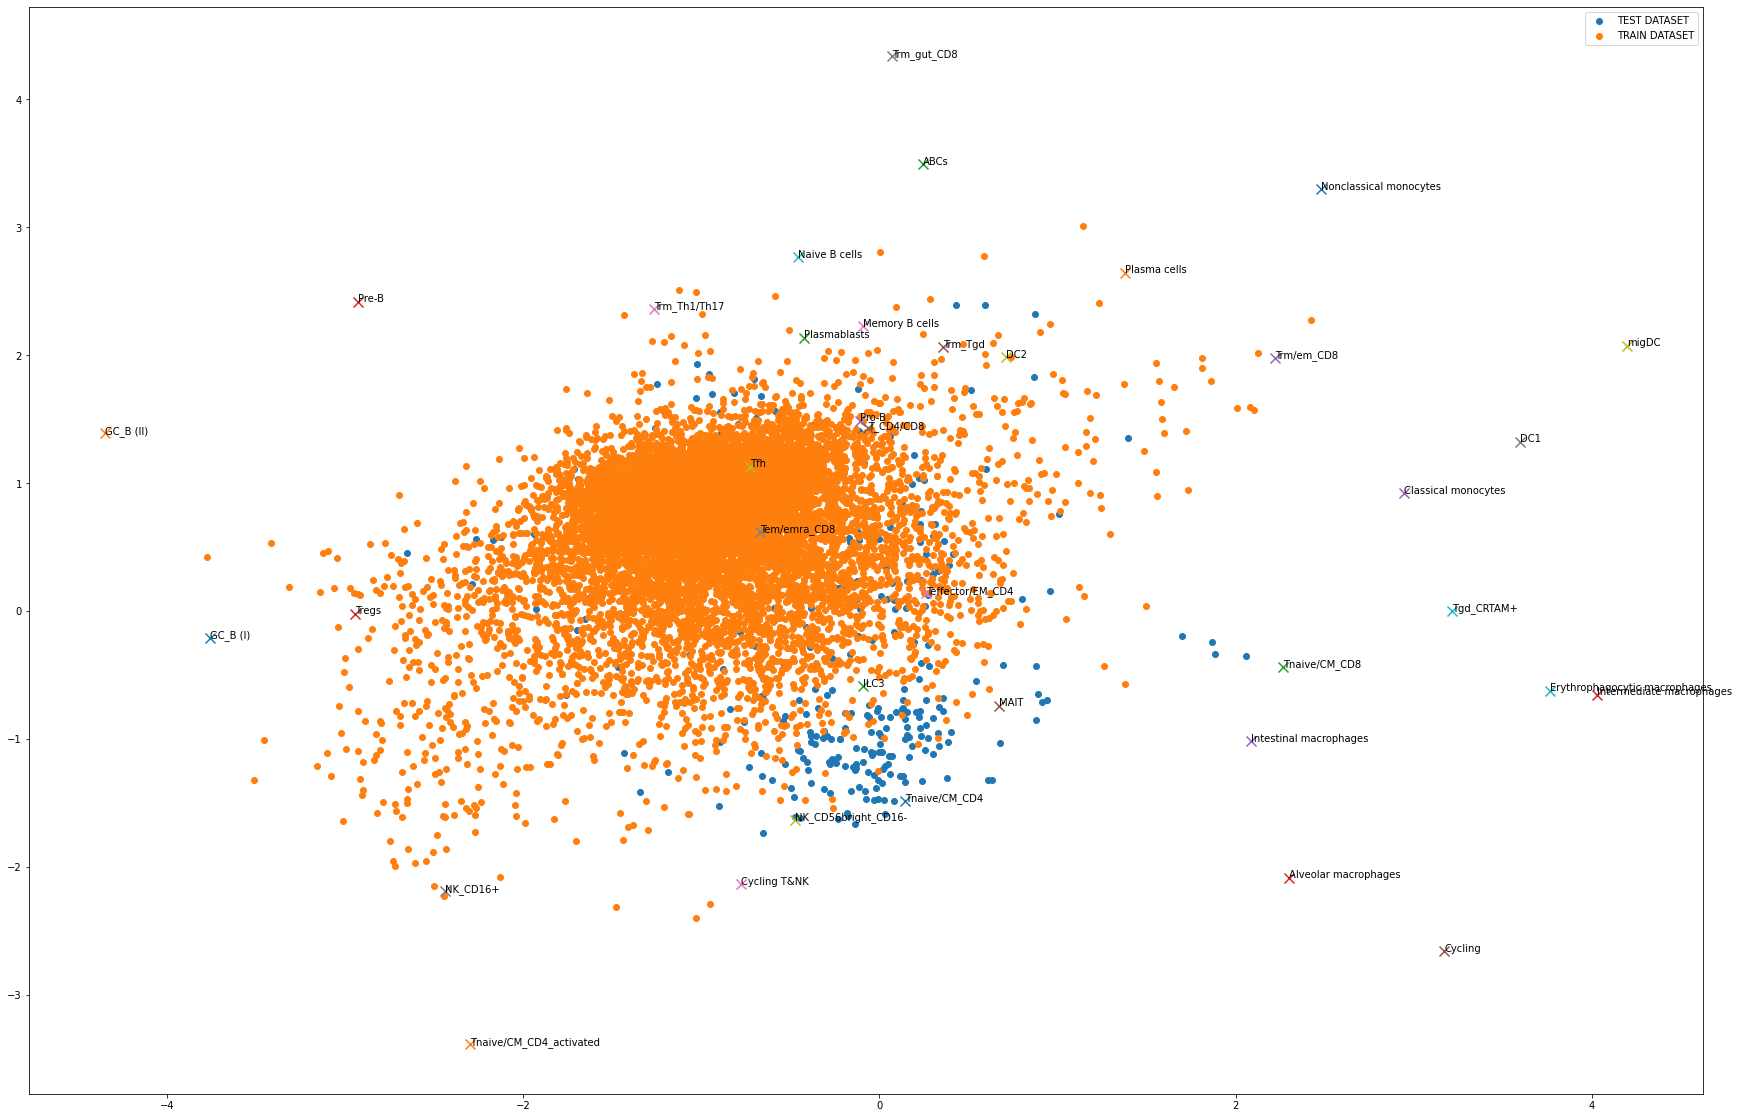

In [ ]:
# helper_fns.plot_embeddings_given_labels_and_datasets(train_embeddings=train_embeddings, test_embeddings=test_embeddings,
#  train_true_labels=dataset_celltypist_pca[train_indices].obs['Manually_curated_celltype'], test_true_labels=dataset_popv_pca.obs['cell_type'],
#  test_pred_labels=test_preds, train_celltype='Tfh', test_celltype='T follicular helper cell', prototypes=prototypes, prototypes_labels=prototypes_labels)

True positive plasma cell: 59.411000433087914%
{'Memory B cells': 32, 'ABCs': 2, 'Naive B cells': 3, 'Plasmablasts': 4040, 'GC_B (I)': 3, 'Cycling T&NK': 7, 'NK_CD16+': 511, 'Tregs': 2, 'Tem/emra_CD8': 5, 'Cycling': 13, 'Classical monocytes': 4, 'ILC3': 12, 'DC2': 11, 'DC1': 1, 'T_CD4/CD8': 1, 'NK_CD56bright_CD16-': 25, 'Trm_Th1/Th17': 2, 'Pro-B': 1, 'Pre-B': 1, 'Trm/em_CD8': 1, 'Alveolar macrophages': 9}


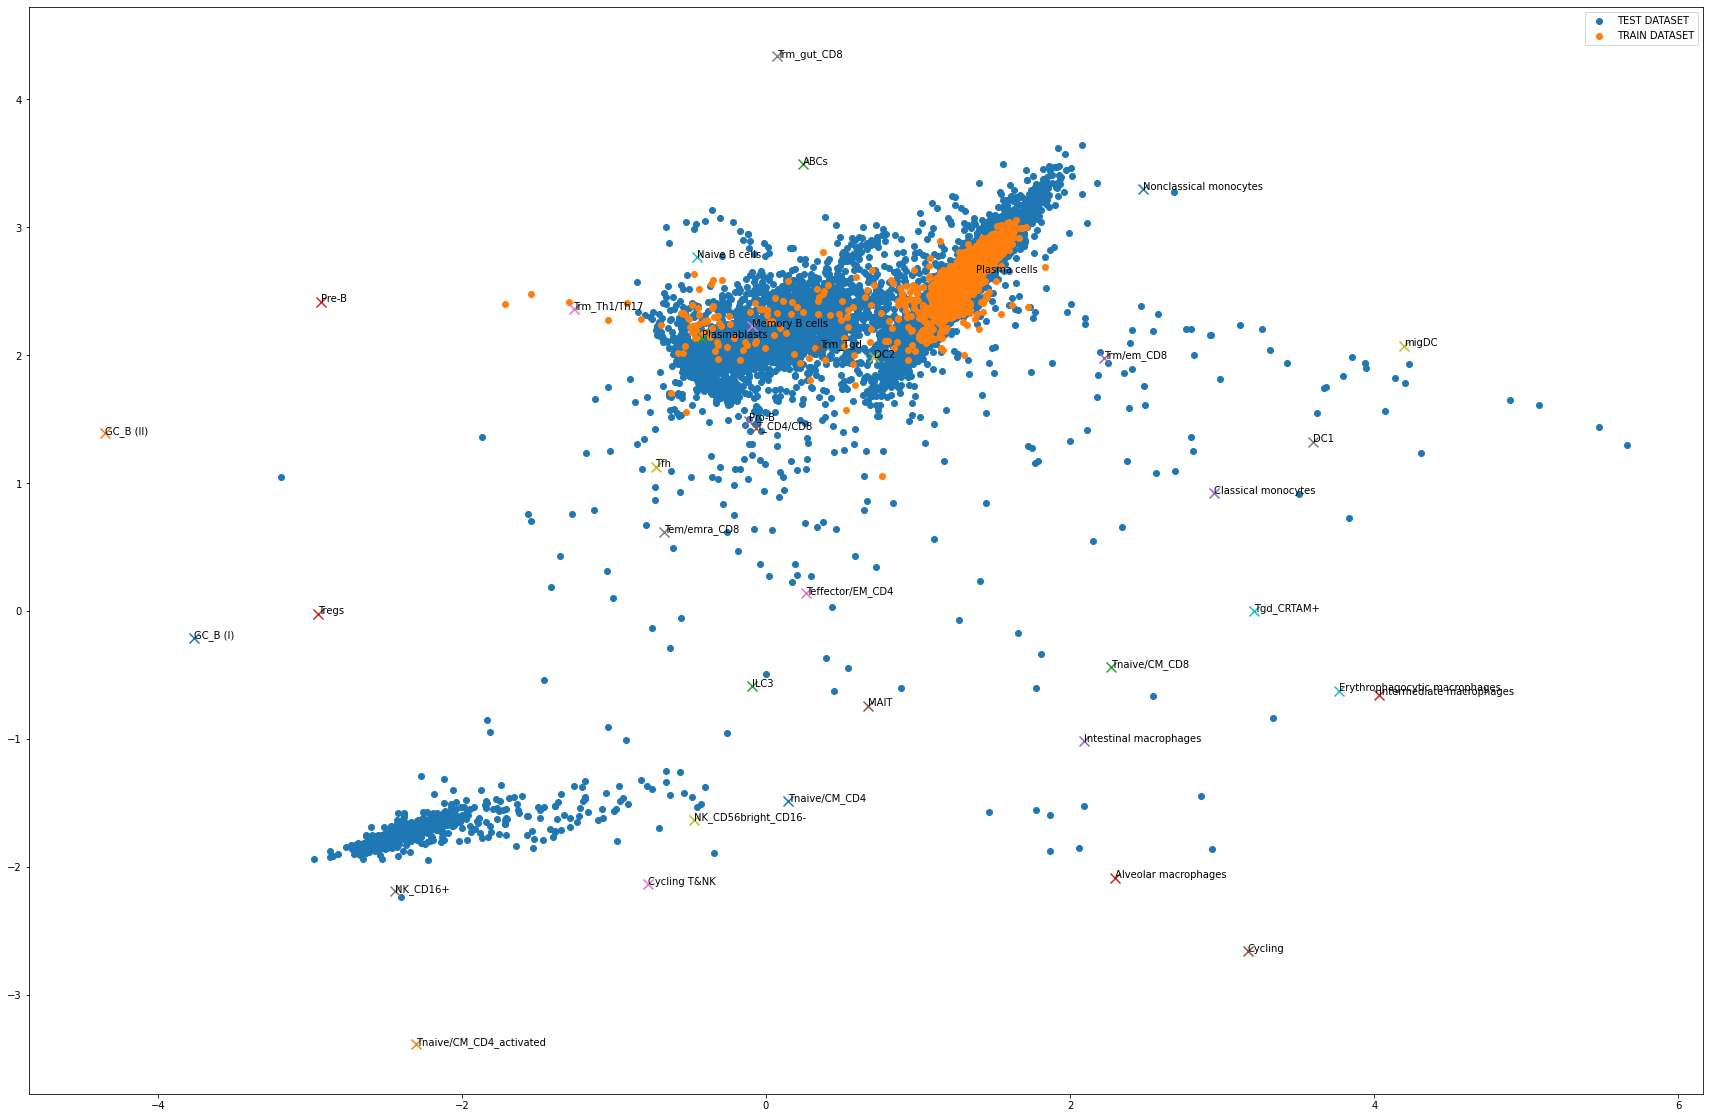

In [ ]:
# helper_fns.plot_embeddings_given_labels_and_datasets(train_embeddings=train_embeddings, test_embeddings=test_embeddings,
#  train_true_labels=dataset_celltypist_pca[train_indices].obs['Manually_curated_celltype'], test_true_labels=dataset_popv_pca.obs['cell_type'],
#  test_pred_labels=test_preds, train_celltype='Plasma cells', test_celltype='plasma cell', prototypes=prototypes, prototypes_labels=prototypes_labels)

True positive regulatory T cell: 84.11358403683806%
{'Memory B cells': 19, 'Tnaive/CM_CD4_activated': 1, 'Tfh': 33, 'Cycling T&NK': 60, 'T_CD4/CD8': 6, 'Tnaive/CM_CD4': 13, 'Trm/em_CD8': 11, 'Teffector/EM_CD4': 32, 'Trm_Th1/Th17': 10, 'Pro-B': 2, 'Tgd_CRTAM+': 3, 'Tem/emra_CD8': 6, 'DC2': 1, 'MAIT': 3, 'ILC3': 4, 'NK_CD56bright_CD16-': 2, 'Tnaive/CM_CD8': 1}


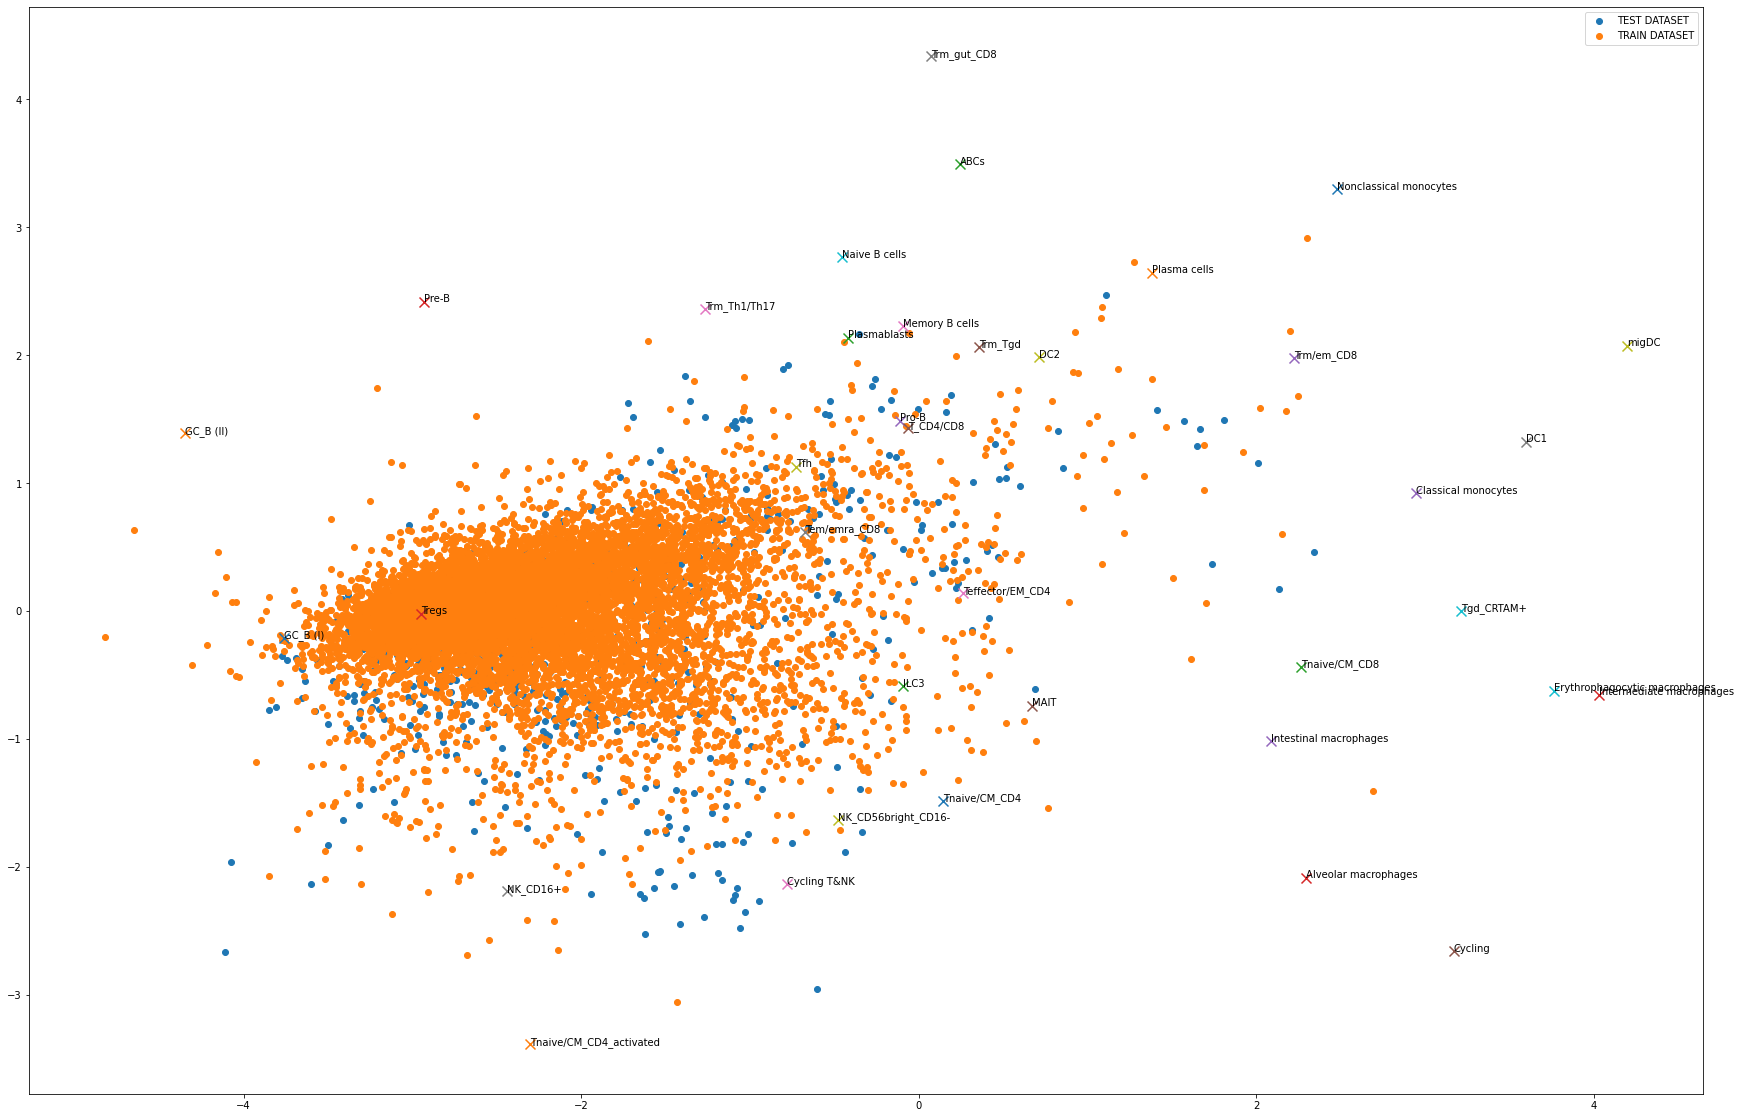

In [ ]:
# helper_fns.plot_embeddings_given_labels_and_datasets(train_embeddings=train_embeddings, test_embeddings=test_embeddings,
#  train_true_labels=dataset_celltypist_pca[train_indices].obs['Manually_curated_celltype'], test_true_labels=dataset_popv_pca.obs['cell_type'],
#  test_pred_labels=test_preds, train_celltype='Tregs', test_celltype='regulatory T cell', prototypes=prototypes, prototypes_labels=prototypes_labels)

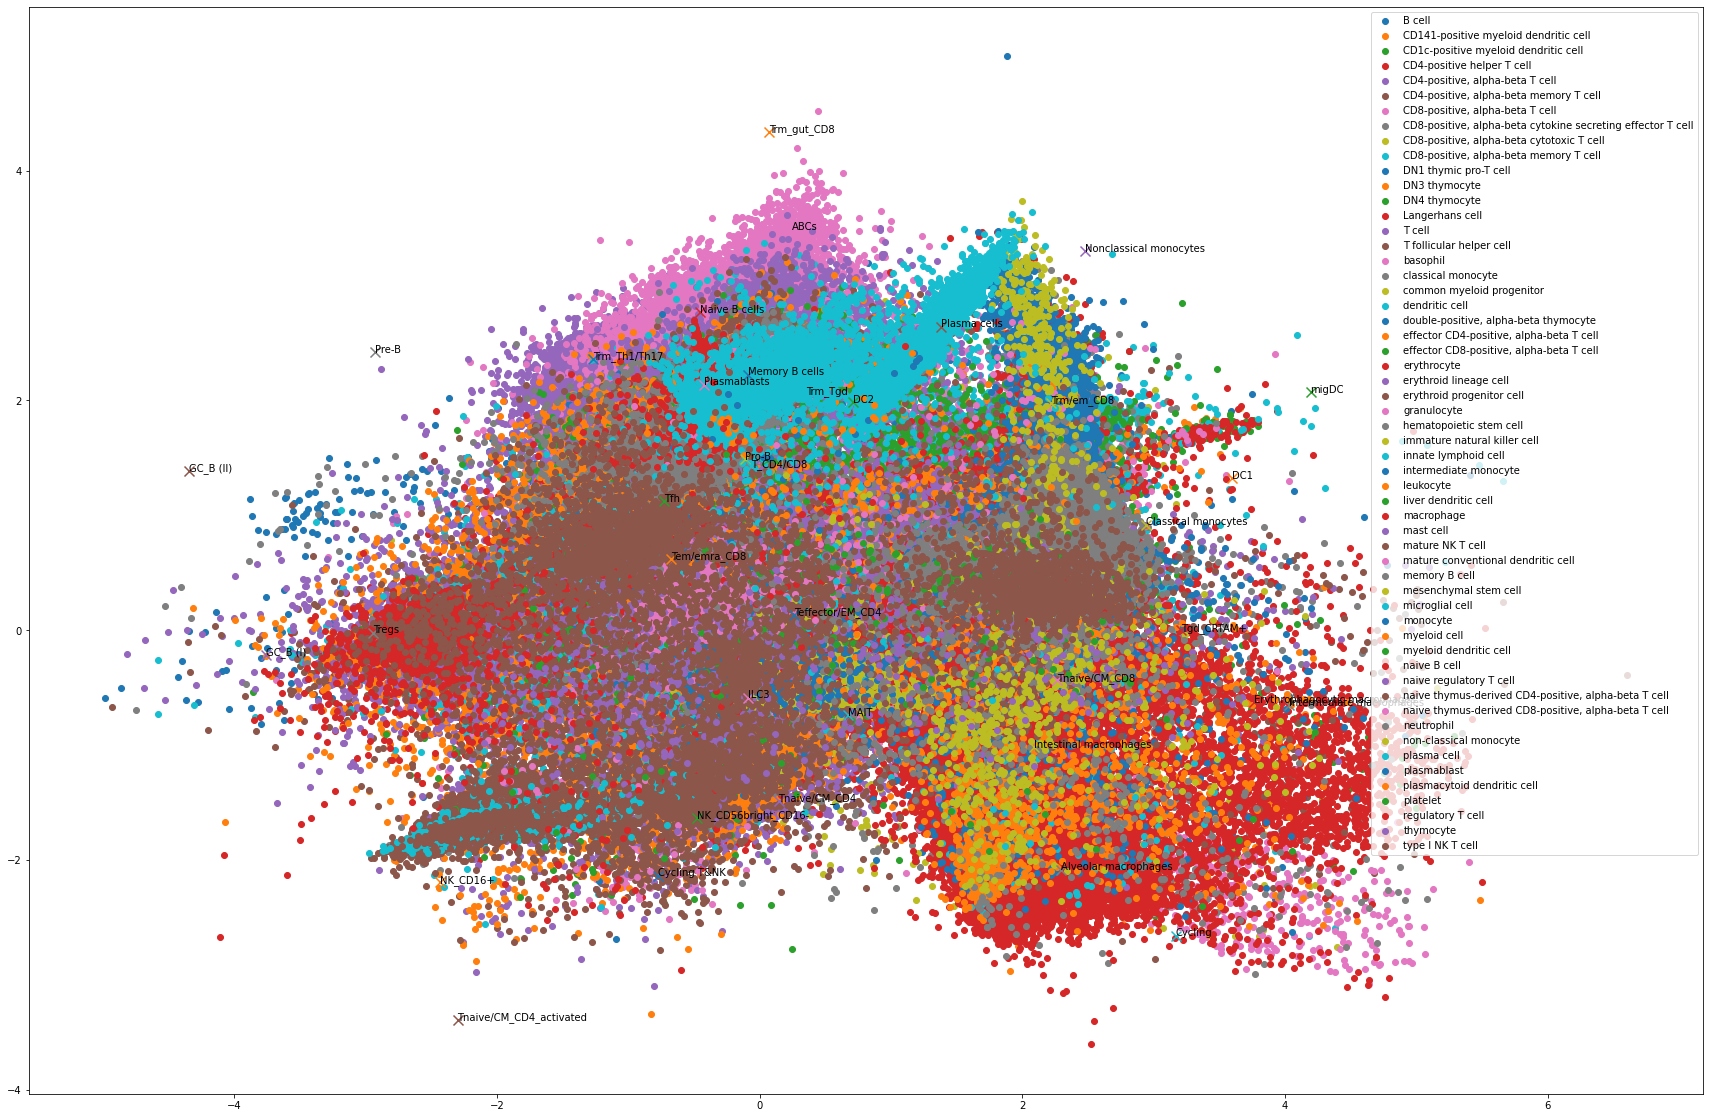

In [ ]:
# helper_fns.plot_embeddings_scatter(embeddings=test_embeddings, true_labels=dataset_popv_pca.obs['cell_type'], 
#     embedding_prototypes=prototypes, embedding_prototypes_labels=prototypes_labels)

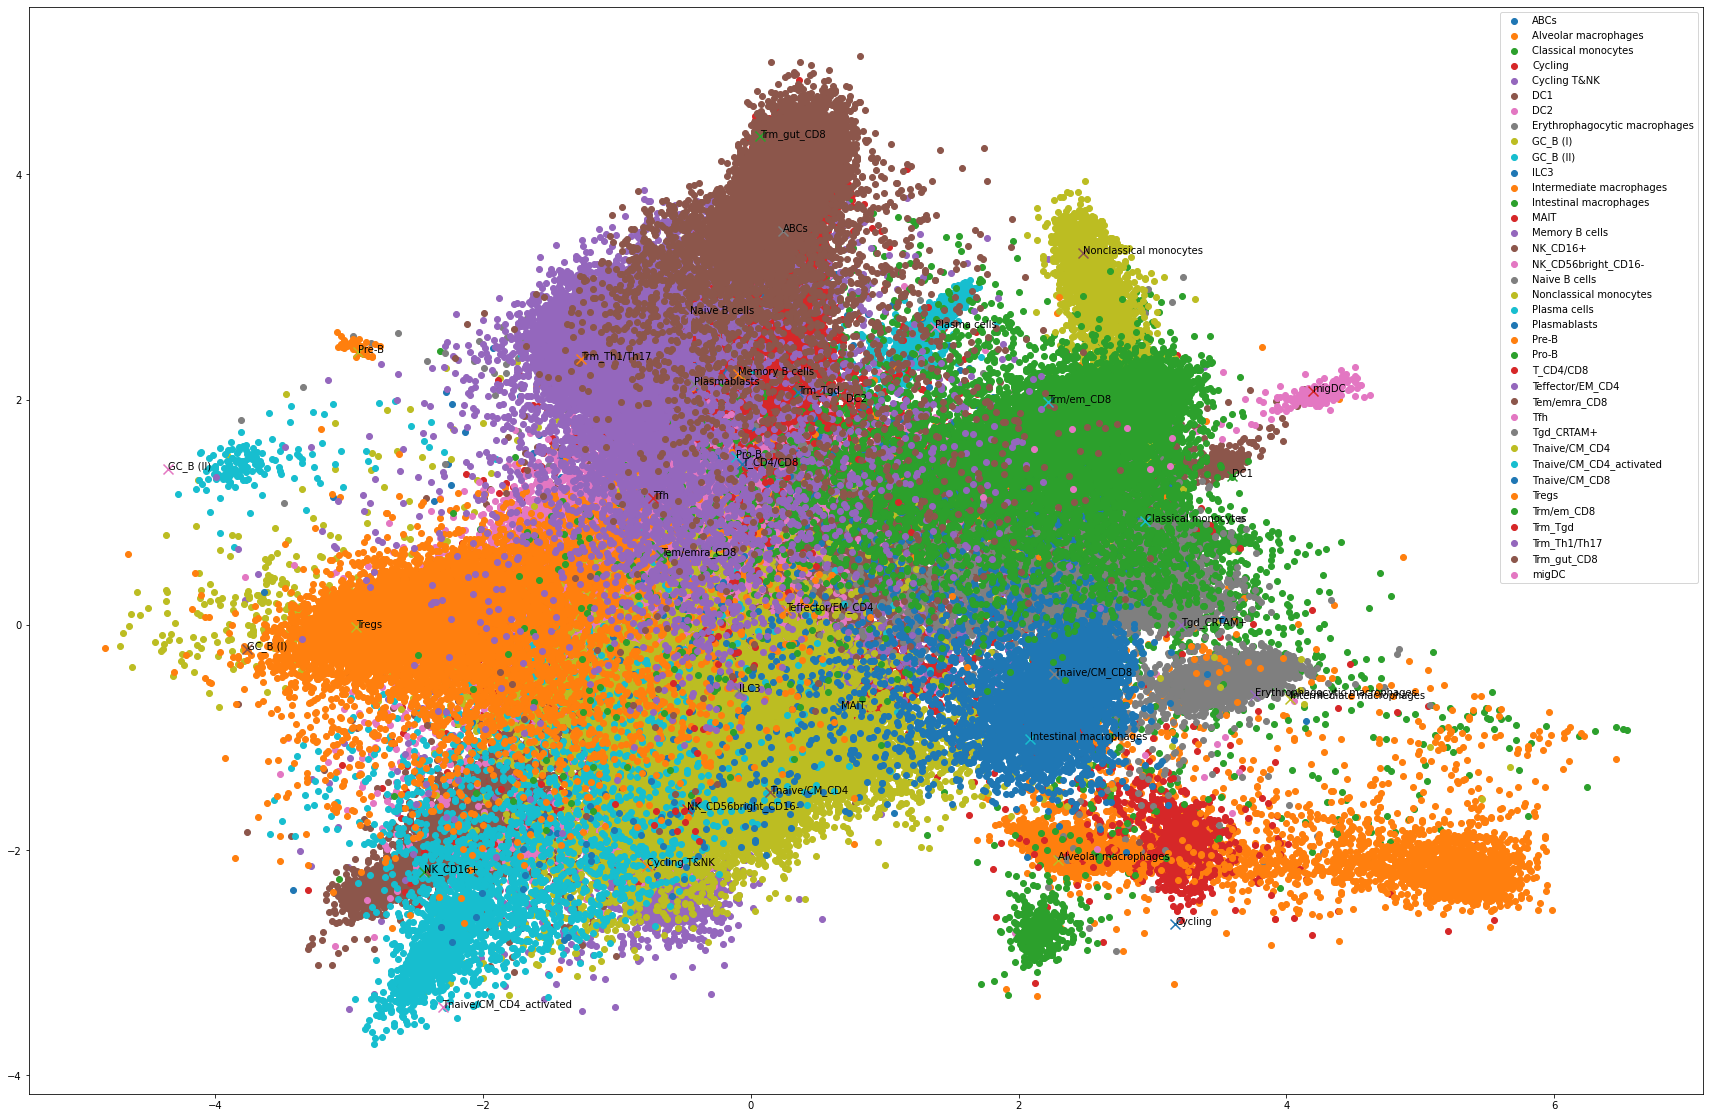

In [ ]:
# helper_fns.plot_embeddings_scatter(embeddings=train_embeddings, true_labels=dataset_celltypist_pca[train_indices].obs['Manually_curated_celltype'], 
#     embedding_prototypes=prototypes, embedding_prototypes_labels=prototypes_labels)

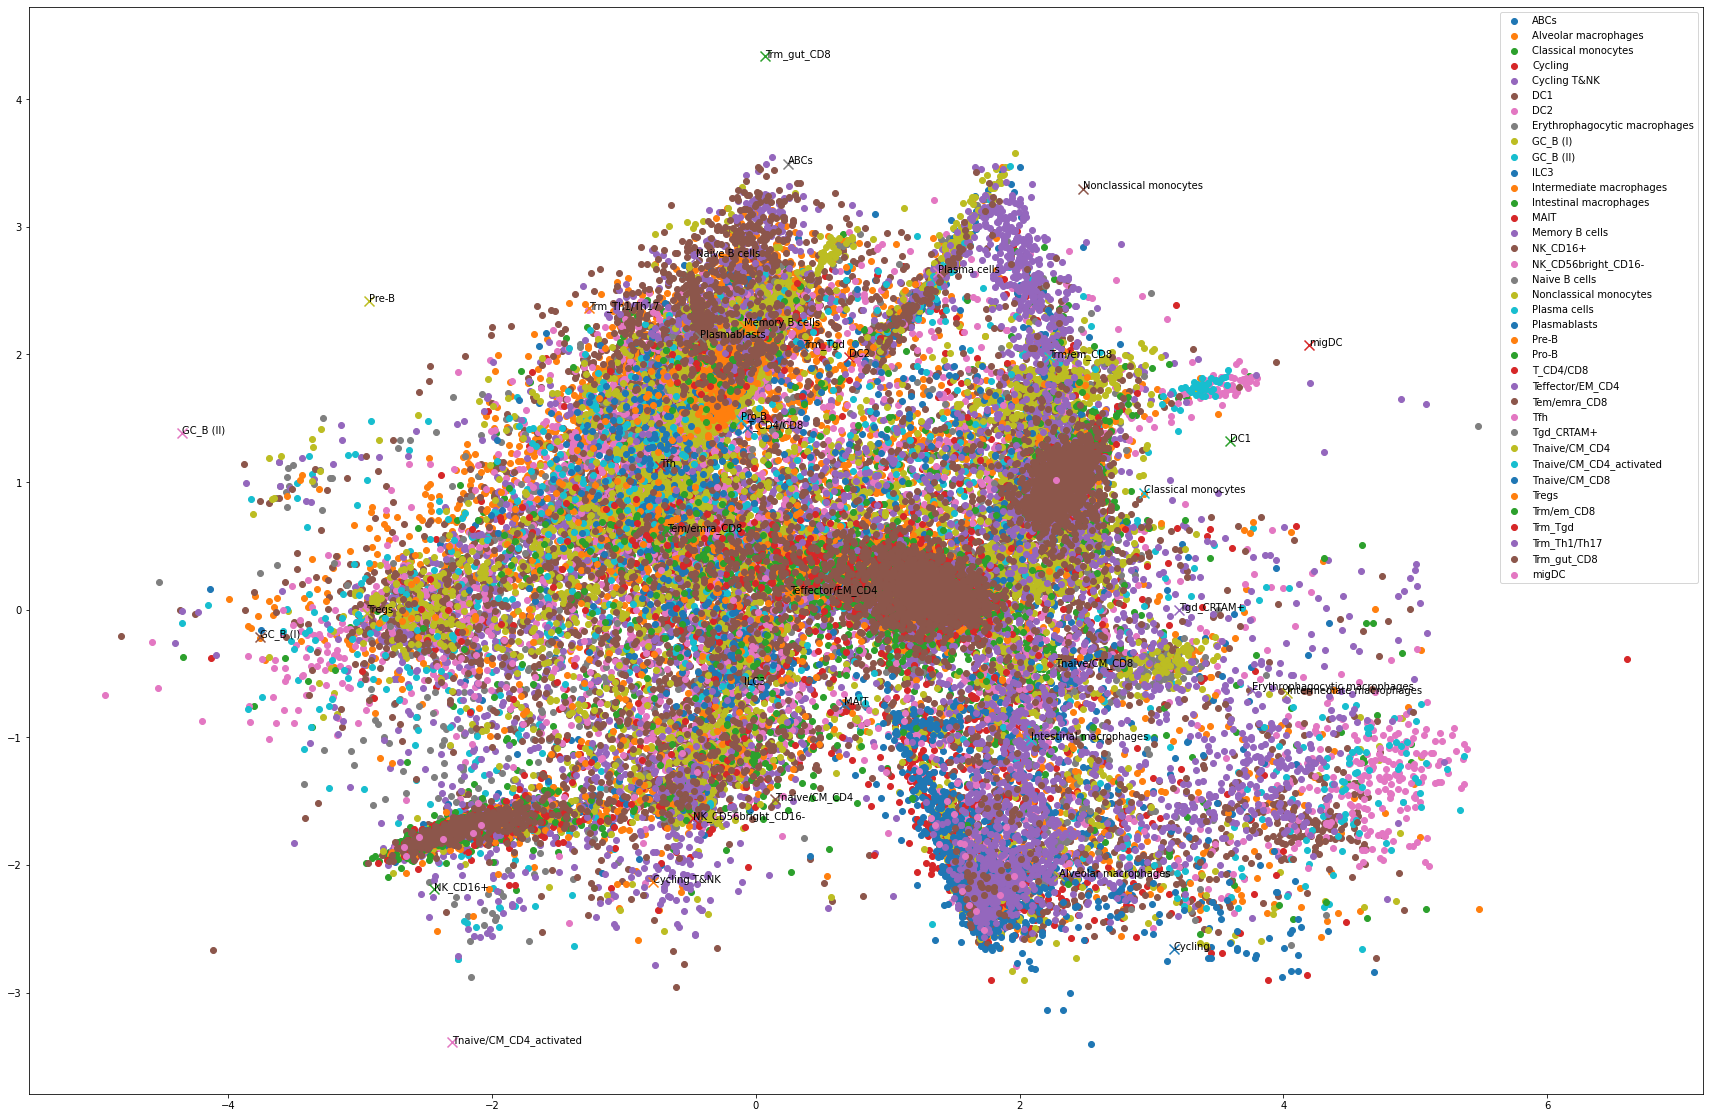

In [ ]:
# helper_fns.plot_embeddings_scatter(embeddings=test_embeddings, true_labels=dataset_celltypist_pca[test_indices].obs['Manually_curated_celltype'], 
#     embedding_prototypes=prototypes, embedding_prototypes_labels=prototypes_labels)

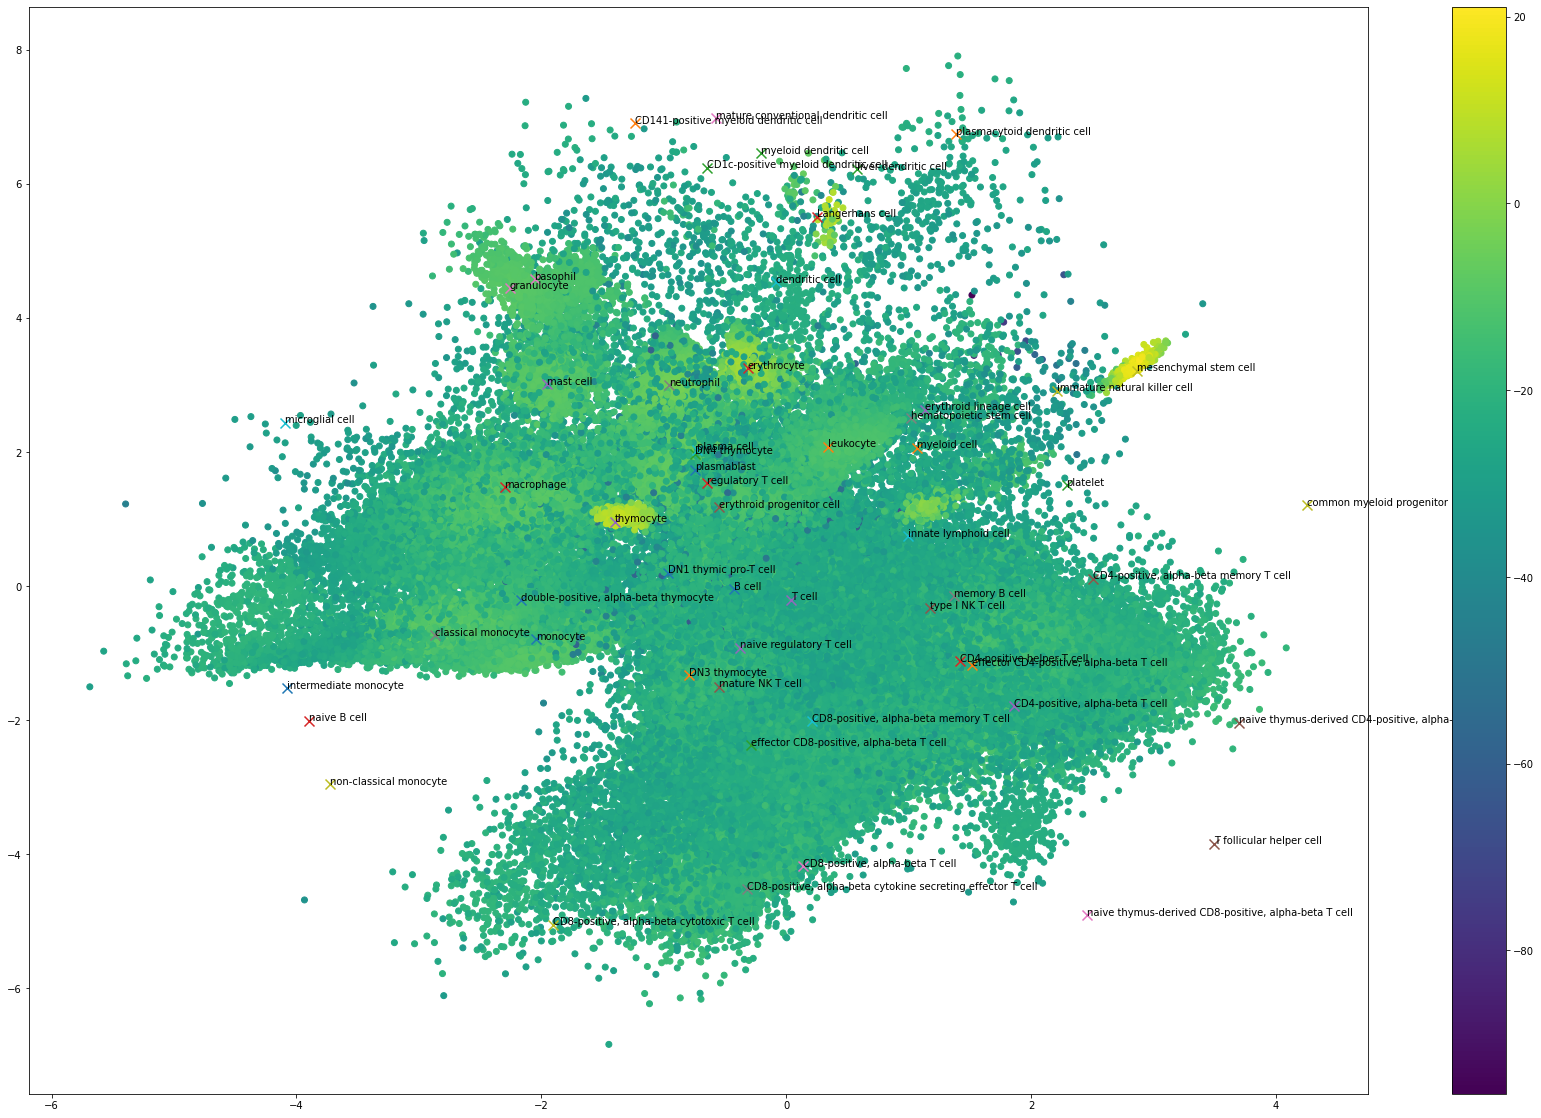

In [8]:
helper_fns.plot_embeddings_likelihood(model=model, encoder=encoder_celltype, pred_labels=training_preds, 
    embeddings=train_embeddings, prototypes=prototypes, prototypes_labels=prototypes_labels)

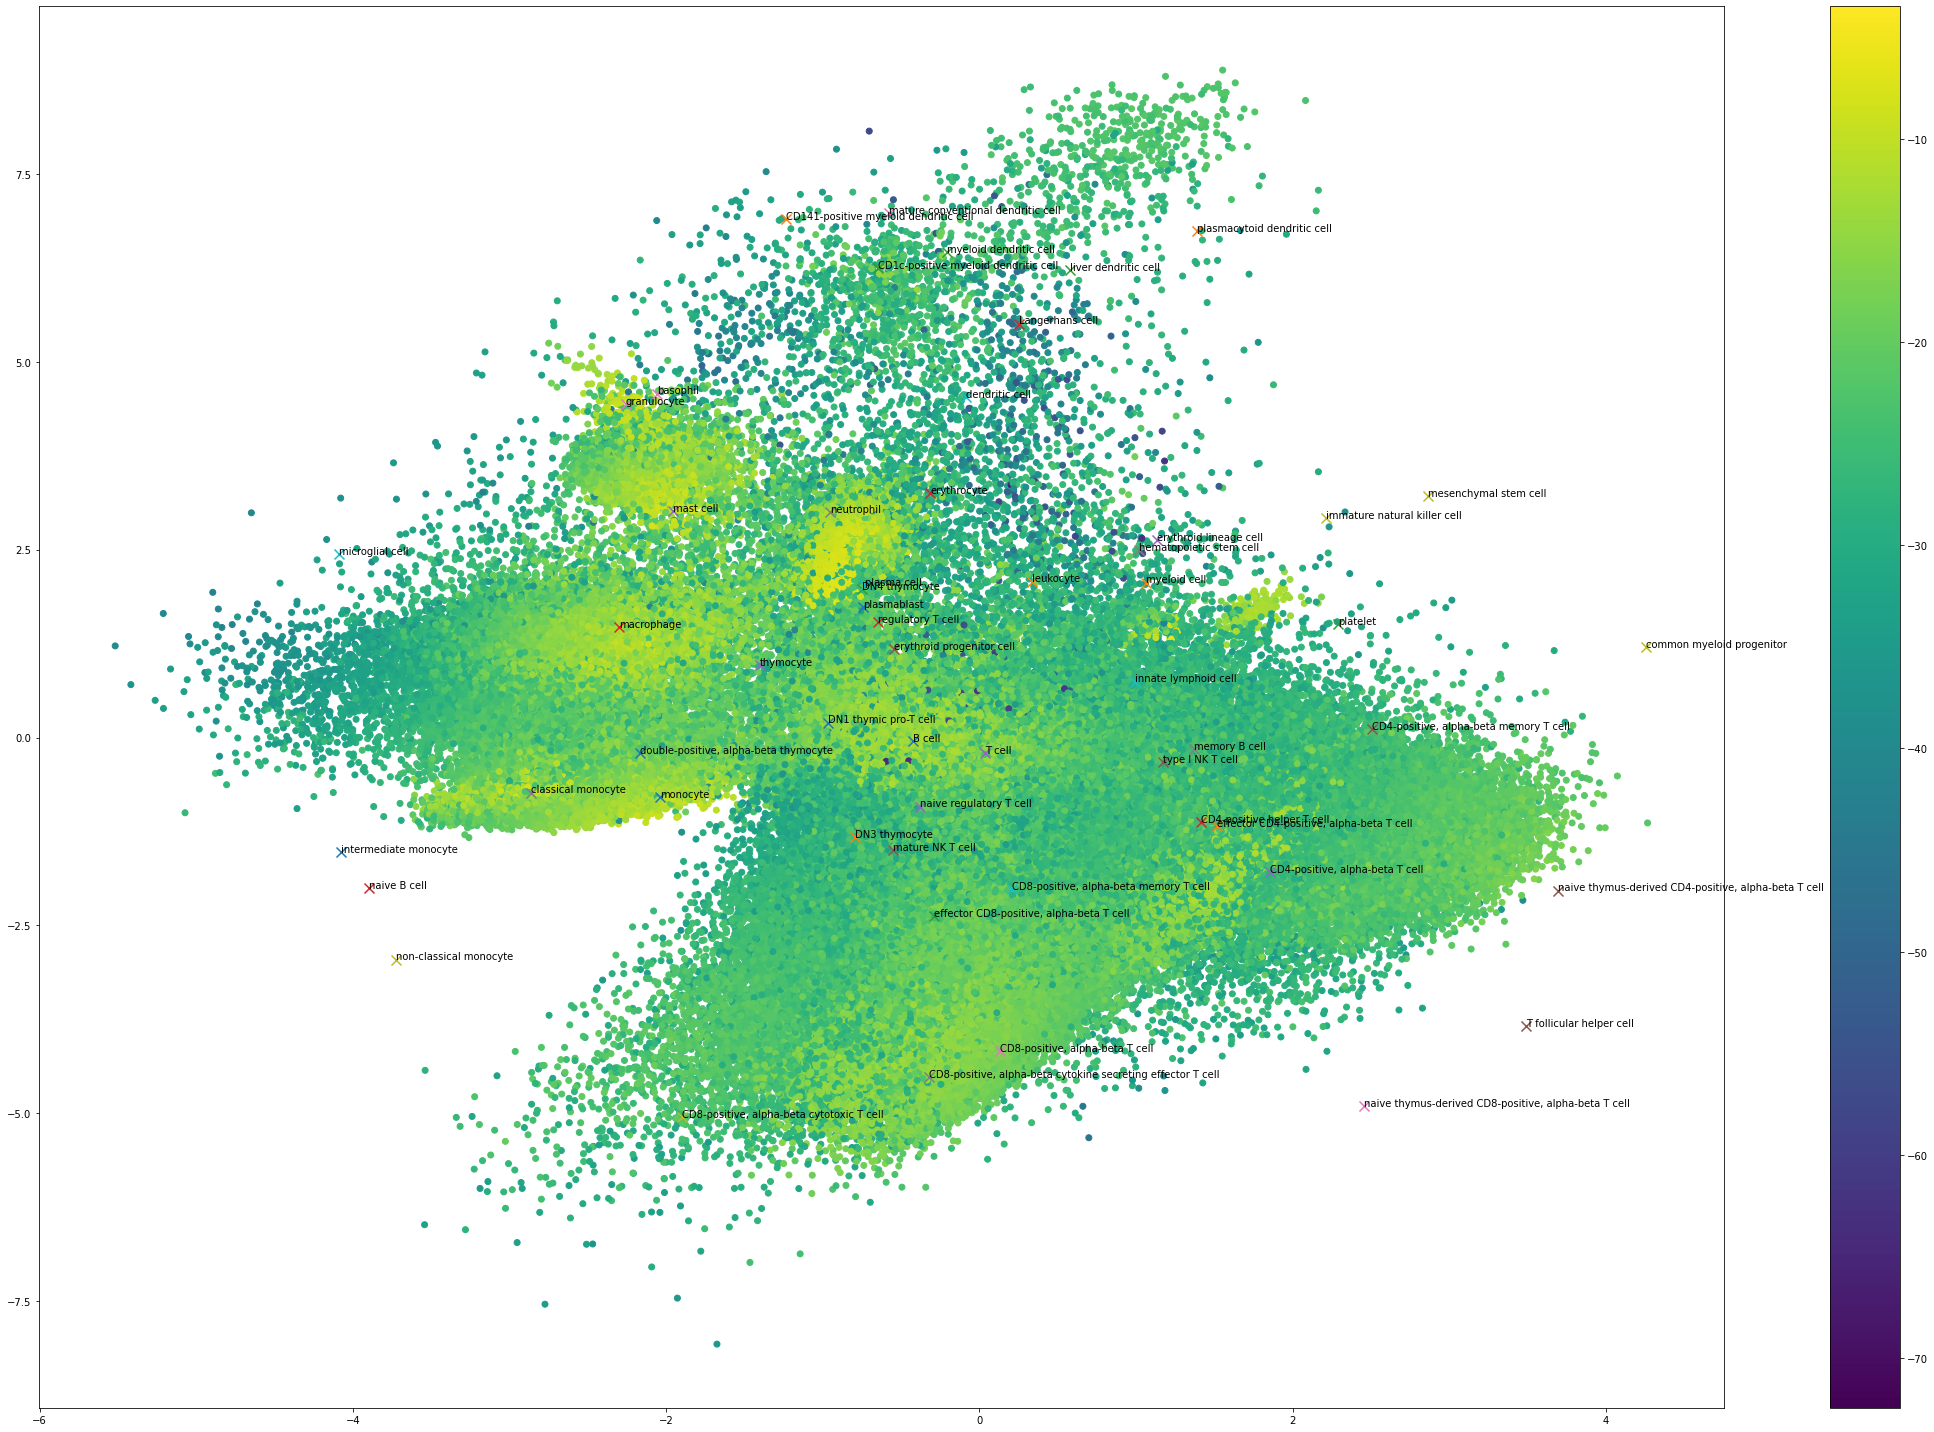

In [9]:
helper_fns.plot_embeddings_likelihood(model=model, encoder=encoder_celltype, pred_labels=test_preds, 
    embeddings=test_embeddings, prototypes=prototypes, prototypes_labels=prototypes_labels)

In [10]:
print("OUR MODEL")
for i in range(len(train_celltypes)):
    print('\n')
    helper_fns.print_true_positive_given_labels_and_datasets(test_true_labels=dataset_celltypist_pca.obs['Manually_curated_celltype'], test_pred_labels=test_preds, 
        train_celltype=train_celltypes[i], test_celltype=test_celltypes[i])

print('\n')
print("Logistic Regression")
test_preds_logistic = encoder_celltype.inverse_transform(model_logistic.predict(dataset_celltypist_pca.X))
for i in range(len(train_celltypes)):
    print('\n')
    helper_fns.print_true_positive_given_labels_and_datasets(test_true_labels=dataset_celltypist_pca.obs['Manually_curated_celltype'], test_pred_labels=test_preds_logistic, 
        train_celltype=train_celltypes[i], test_celltype=test_celltypes[i])

print('\n')
print("kNN")
test_preds_knn = encoder_celltype.inverse_transform(model_knn.predict(dataset_celltypist_pca.X))
for i in range(len(train_celltypes)):
    print('\n')
    helper_fns.print_true_positive_given_labels_and_datasets(test_true_labels=dataset_celltypist_pca.obs['Manually_curated_celltype'], test_pred_labels=test_preds_knn, 
        train_celltype=train_celltypes[i], test_celltype=test_celltypes[i])

OUR MODEL


True positive Memory B cells: 13.446308144561648%
{'B cell': 24503, 'CD4-positive, alpha-beta T cell': 9, 'naive B cell': 426, 'plasma cell': 71, 'leukocyte': 4, 'macrophage': 3, 'dendritic cell': 9, 'mature conventional dendritic cell': 2}


True positive Naive B cells: 45.47792541791685%
{'B cell': 7490, 'memory B cell': 116, 'myeloid cell': 1, 'plasma cell': 21, 'dendritic cell': 2, 'mature conventional dendritic cell': 1, 'hematopoietic stem cell': 1}


True positive Tfh: 0.8173674230039887%
{'T cell': 1753, 'effector CD4-positive, alpha-beta T cell': 7496, 'CD4-positive, alpha-beta T cell': 430, 'regulatory T cell': 139, 'effector CD8-positive, alpha-beta T cell': 96, 'CD4-positive helper T cell': 1458, 'type I NK T cell': 329, 'naive regulatory T cell': 52, 'CD4-positive, alpha-beta memory T cell': 2970, 'macrophage': 1, 'innate lymphoid cell': 21, 'naive thymus-derived CD4-positive, alpha-beta T cell': 395, 'CD8-positive, alpha-beta memory T cell': 7, 'CD8-positive, 